# Remerge Model

In [1]:
from network import Remerge
from helpers import softmax, response_time
from plotting import plotting_init, matrix_plot, mds_plot

import numpy as np
from sklearn import manifold
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns

## Run simulations and create Plots

In [2]:
blue, blue2, red, red2, magma_3 = plotting_init()

### Choice matrix

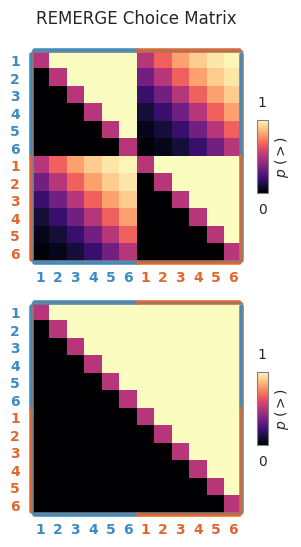

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(4, 6))
fig.patch.set_facecolor('white')

for i, stitched in enumerate([False, True]):
    items_n = 12
    rmg = Remerge(items_n)
    rmg.is_stitched(stitched)
    ts = np.linspace(0., 500., 1000)
    choice = np.zeros((items_n, items_n))
    for left in range(items_n):
        for right in range(items_n):
            response = rmg.run(left, right, ts)[1]
            response = response[[left, right]].T
            choice[left, right] = 1. - softmax(response[-1, :])[0]

    vmax = 1
    vmin = 0
    im = matrix_plot(choice, axs[i], items_n)
    cbar = fig.colorbar(im, ax=axs[i], anchor=(0., 0.5), shrink=.35, aspect=7.)
    cbar.set_ticks([])
    cbar.ax.text(0.5, 1.2, vmax, ha='center', va='center')
    cbar.ax.text(0.5, -0.2, vmin, ha='center', va='center')
    cbar.set_label("$p\ (>)$")
    cbar.outline.set_edgecolor([0.5] * 3)

axs[0].set_title("REMERGE Choice Matrix", pad=20.);

### Reaction times

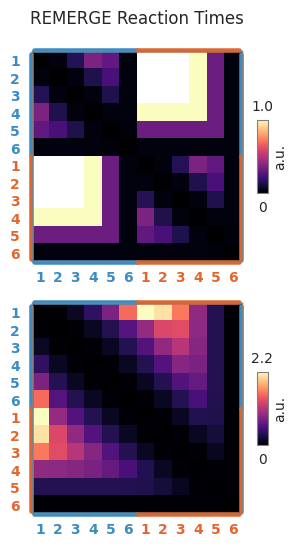

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(4, 6))
fig.patch.set_facecolor('white')

for i, stitched in enumerate([False, True]):
    items_n = 12
    rmg = Remerge(items_n)
    rmg.is_stitched(stitched)
    ts = np.linspace(0., 400, 8000)
    reaction_times = np.zeros((items_n, items_n))
    for left in range(items_n):
        for right in range(items_n):
            if left == right:
                reaction_times[left, right] = 0.
            else:
                response = rmg.run(left, right, ts)[1]
                response = response[[left, right]].T
                item = np.argmax(softmax(response[-1, :]))
                reaction_times[left, right] = response_time(response[:, item], .13) # np.max(np.abs(response[-1, :])) # reaction_time(response, .32)
    
    vmin = 0
    vmax = np.round(np.max(reaction_times[~np.isnan(reaction_times)]) / 647., 1)
    reaction_times /= 647
    im = matrix_plot(reaction_times, axs[i], items_n)
    cbar = fig.colorbar(im, ax=axs[i], anchor=(0., 0.5), shrink=.35, aspect=7.)
    cbar.set_ticks([])
    cbar.ax.text(0.5, vmax * 1.18, vmax, ha='center', va='center')
    cbar.ax.text(0.5, -.2 - i * 0.22, vmin, ha='center', va='center')
    cbar.set_label("a.u.")
    cbar.outline.set_edgecolor([0.5] * 3)

axs[0].set_title("REMERGE Reaction Times", pad=20.);

## MDS

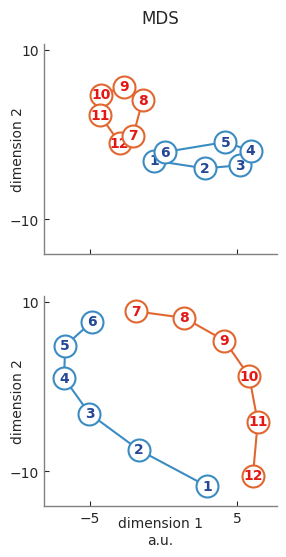

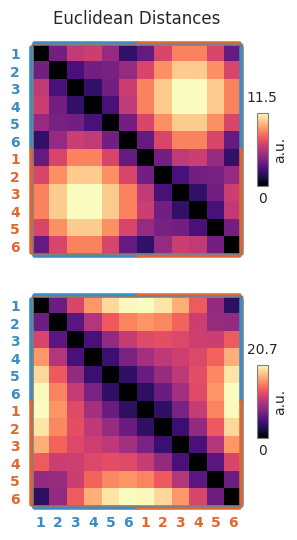

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(3, 6), sharex=True, sharey=True)
all_distances = []
for i, stitched in enumerate([False, True]):
    items_n = 12
    rmg = Remerge(items_n)
    rmg.is_stitched(stitched)
    ts = np.linspace(0., 500, 1000)
    
    h1s = np.zeros((items_n, items_n-1))
    for item in range(items_n):
        h1s[item] = rmg.run(item, -1, ts)[0][-1]
    
    distances = euclidean_distances(h1s)
    all_distances.append(distances)
    mds = manifold.MDS(n_components=2, eps=1e-9, dissimilarity="precomputed", random_state=1,
                       normalized_stress="auto")
    d1, d2 = mds.fit(distances).embedding_.T
    mds_plot((d1, d2), axs[i], items_n)

axs[0].set_title("MDS", pad=15.)

for i in range(2):
    # Set border color
    for pos in ["left", "bottom"]:
        axs[i].spines[pos].set_linewidth(1)
        axs[i].spines[pos].set_color([0.5]*3)

    axs[i].set_xticks([-5, 5])
    axs[i].set_ylabel("dimension 2", labelpad=-11.)
axs[1].set_xlabel("dimension 1\na.u.", labelpad=-6.)
axs[0].set_yticks([-10, 10])

fig, axs = plt.subplots(2, 1, figsize=(4, 6), sharex=True, sharey=True)
for i in range(2):
    im = matrix_plot(all_distances[i], axs[i], items_n, vmin=0)
    
    vmin = 0
    vmax = np.round(np.max(all_distances[i]), 1)
    
    cbar = fig.colorbar(im, ax=axs[i], anchor=(0., 0.5), shrink=.35, aspect=7.)
    cbar.set_ticks([])
    cbar.ax.text(0.5, vmax*1.2, vmax, ha='center', va='center')
    cbar.ax.text(0.5, -2. - i * 1.5, vmin, ha='center', va='center')
    cbar.set_label("a.u.")
    cbar.outline.set_edgecolor([0.5] * 3)

axs[0].set_title("Euclidean Distances", pad=15.);

## Race Condition

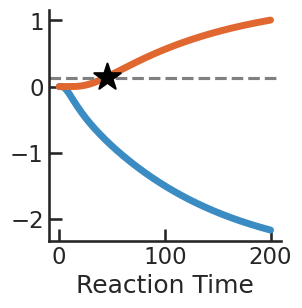

In [6]:
sns.set_context("talk")
items_n = 12

rmg = Remerge(items_n)
rmg.is_stitched(True)

ts = np.linspace(0., 200, 12000)
threshold = 0.13

left = 1
right = 8

hs, outputs = rmg.run(left, right, ts)

fig, ax = plt.subplots(figsize=(3, 3), sharey=True)
outputs = outputs[[left, right]]
threshold = 0.13
for i, output in zip([left, right], outputs):
    c = red if i == right else blue
    ax.plot(ts, output, color=c, lw=5., label=i)
ax.axhline(threshold, color="grey", linestyle="--", label="Threshold")
ax.scatter(45, threshold*1.1, marker="*", zorder=3, s=400, c=["k"])
#ax.legend(frameon=False)
ax.set_yticks([-2, -1, 0, 1])
ax.set_xticks([0, 100, 200])
ax.set_xlabel("Reaction Time")
sns.despine()